In [2]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from io import StringIO
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler

from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [3]:
fetcher = DataFetcher(DB_PARAMS)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:132: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:107: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [4]:
df = fetcher.fetch_data(
      regressors=[
       'avg_default_verbolizer', 
       'avg_shrink_verbolizer',
       'max_abs_default',
       'max_abs_shrink',
        'max_default_verbolizer',
        'max_shrink_verbolizer',
        'min_default_verbolizer',
        'min_shrink_verbolizer',
        'eps_surprise',
        'f_size',
        'doc_len'
       ],
   prepare_fixed_effects=True
)

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:164: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:211: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:226: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBA

In [5]:
df.isna().sum()

report_type                 0
avg_default_verbolizer      0
avg_shrink_verbolizer       0
max_abs_default             0
max_abs_shrink              0
max_default_verbolizer      0
max_shrink_verbolizer       0
min_default_verbolizer      0
min_shrink_verbolizer       0
eps_surprise               86
f_size                      0
doc_len                     0
two_day_r                   0
three_day_r                 0
four_day_r                  0
five_day_r                  0
six_day_r                   0
seven_day_r                 0
full_q_r                  360
two_day_e_r                 0
three_day_e_r               0
four_day_e_r                0
five_day_e_r                0
six_day_e_r                 0
seven_day_e_r               0
full_q_e_r                360
two_day_abn_r               0
three_day_abn_r             0
four_day_abn_r              0
five_day_abn_r              0
six_day_abn_r               0
seven_day_abn_r             0
full_q_abn_r              360
two_day_r_

In [22]:
class FEModeler:
    """
    A class to run panel fixed effects regressions using PanelOLS
    and extract key parameter statistics for a specified regressor.

    Attributes:
        df: The input panel data.
        var_names: Column names of the input DataFrame.
        params_dict: Dictionary storing regression parameters for each independent variable.
    """

    def __init__(self, df: pd.DataFrame, scale: bool = False):
        """
        Initialize the FEModeler with panel data.

        Args:
            df: Panel DataFrame with MultiIndex (entity, time).
            scale: Whether to standardize the regressors.
        """
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}
        self.scale = scale

        if scale:
            self._scale_regressors()

    def _scale_regressors(self):
        """
        Standardize regressors: columns 1 to 8 (your x variables), plus control variables eps_surprise, f_size.
        Scaling is done entity-wise (within-entity).
        """
        x_cols = list(self.df.columns[1:9]) + ['eps_surprise', 'f_size']
        scaler = StandardScaler()

        # Scale within each entity group
        for entity in self.df.index.get_level_values(0).unique():
            entity_mask = self.df.index.get_level_values(0) == entity
            sub_df = self.df.loc[entity_mask, x_cols]
            if sub_df.shape[0] < 2:
                continue
            self.df.loc[entity_mask, x_cols] = scaler.fit_transform(sub_df)


    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        """
        Extract parameter statistics for a given regressor from the regression summary.

        Args:
            summary: The PanelOLS regression summary object.
            regressor_name: The name of the regressor to extract parameters for.

        Returns:
            A Series containing coefficient, std error, p-value, and confidence intervals.
        """
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        """
        Fit a fixed effects regression model using PanelOLS.

        Args:
            data: A subset of the full DataFrame containing required variables.
            formula: Regression formula in Patsy-style syntax.

        Returns:
            The regression summary object.
        """
        model = PanelOLS.from_formula(formula, data=data, check_rank=True)
        result = model.fit(cov_type='kernel')
        return result.summary

    def compute(self) -> dict[str, list[pd.Series]]:
        """
        Run fixed effects regressions for all combinations of independent and dependent variables,
        and store the parameter summaries for each independent variable.

        Returns:
            A dictionary where keys are independent variable names,
            and values are lists of Series with parameter info for each dependent variable.
        """
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter' ]

        var_names = self.df.columns 

        for x in range(1, 9):
            # Targets starts from y index
            y = 12

            per_target_params = {}
            for target in targets:  
                if target not in per_target_params:
                    per_target_params[target] = {}

                for frame in time_frames:
                    print(self.df.columns[x], self.df.columns[y])

                    data = self.df.iloc[:, [x, 9, 10, 11, y]].dropna().copy()

                    formula = f"{var_names[y]} ~ {var_names[x]} + eps_surprise + f_size + EntityEffects + TimeEffects"
                    try:
                        result_summary = self.fit(data, formula)
                        print(result_summary)
                        param_info = self.extract_params(result_summary, self.var_names[x])
                        per_target_params[target][self.df.columns[y]] = param_info
                        
                    except Exception as e:
                        print(e)
                    y += 1

            self.params_dict[self.df.columns[x]] = per_target_params

        return self.params_dict
    
    def plot_all_params(self):
        """
        Plot bar charts for each regressor–target combination.
        Each chart shows 7 timeframes with confidence intervals.
        """
        for regressor, target_dict in self.params_dict.items():
            for target, outcomes in target_dict.items():
                keys = list(outcomes.keys())
                if len(keys) < 1:
                    continue

                x = np.arange(len(keys))
                params = [outcomes[k]['Parameter'] for k in keys]
                lower = [outcomes[k]['Lower CI'] for k in keys]
                upper = [outcomes[k]['Upper CI'] for k in keys]

                plt.figure(figsize=(8, 6))
                plt.bar(x, params, width=0.4, color='tab:blue', label=regressor)

                # Confidence intervals
                for i in range(len(keys)):
                    plt.plot([x[i], x[i]], [lower[i], upper[i]], color='black', linewidth=1.5)

                plt.axhline(0, color='black', linewidth=1)
                plt.xticks(x, keys, rotation=45)
                plt.title(f"{regressor} on {target}")
                plt.xlabel('Time frame')
                plt.ylabel('Beta coefficient')
                plt.tight_layout()

                ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
                plt.legend(handles=[ci_legend])
                plt.show()


In [23]:
df.columns

Index(['report_type', 'avg_default_verbolizer', 'avg_shrink_verbolizer',
       'max_abs_default', 'max_abs_shrink', 'max_default_verbolizer',
       'max_shrink_verbolizer', 'min_default_verbolizer',
       'min_shrink_verbolizer', 'eps_surprise', 'f_size', 'doc_len',
       'two_day_r', 'three_day_r', 'four_day_r', 'five_day_r', 'six_day_r',
       'seven_day_r', 'full_q_r', 'two_day_e_r', 'three_day_e_r',
       'four_day_e_r', 'five_day_e_r', 'six_day_e_r', 'seven_day_e_r',
       'full_q_e_r', 'two_day_abn_r', 'three_day_abn_r', 'four_day_abn_r',
       'five_day_abn_r', 'six_day_abn_r', 'seven_day_abn_r', 'full_q_abn_r',
       'two_day_r_vol', 'three_day_r_vol', 'four_day_r_vol', 'five_day_r_vol',
       'six_day_r_vol', 'seven_day_r_vol', 'full_q_r_vol'],
      dtype='object')

In [24]:
df.isna().sum()

report_type                   0
avg_default_verbolizer        0
avg_shrink_verbolizer         0
max_abs_default               0
max_abs_shrink                0
max_default_verbolizer        0
max_shrink_verbolizer         0
min_default_verbolizer        0
min_shrink_verbolizer         0
eps_surprise                 12
f_size                        0
doc_len                       0
two_day_r                     0
three_day_r                   0
four_day_r                    0
five_day_r                    0
six_day_r                     0
seven_day_r                   0
full_q_r                    430
two_day_e_r                   0
three_day_e_r                 0
four_day_e_r                  0
five_day_e_r                  0
six_day_e_r                   0
seven_day_e_r                 0
full_q_e_r                  430
two_day_abn_r                 0
three_day_abn_r               0
four_day_abn_r                0
five_day_abn_r                0
six_day_abn_r                 0
seven_da

In [30]:
model = FEModeler(df=df, scale=True)
res = model.compute()

avg_default_verbolizer two_day_r
                          PanelOLS Estimation Summary                           
Dep. Variable:              two_day_r   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):          -2.079e+15
No. Observations:               13028   R-squared (Within):               0.0033
Date:                Tue, May 06 2025   R-squared (Overall):           -3.88e+12
Time:                        16:50:11   Log-likelihood                -2.707e+04
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      9.0112
Entities:                         496   P-value                           0.0000
Avg Obs:                       26.266   Distribution:                 F(3,12502)
Min Obs:                       1.0000                                           
Max Obs:                       28.000   F-statistic (robust):             11

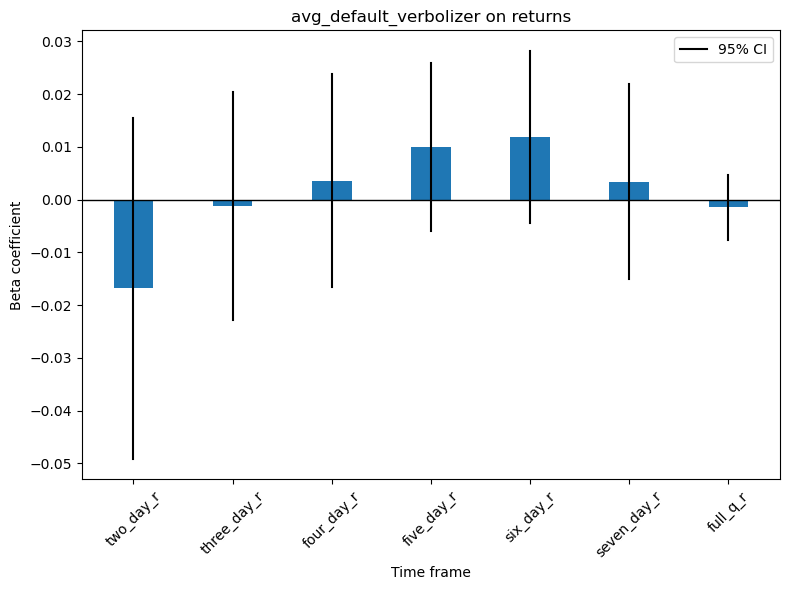

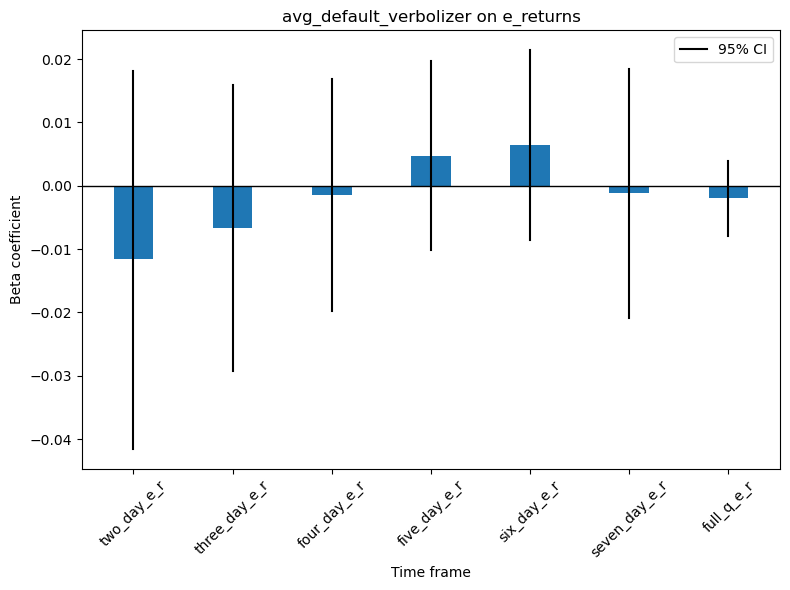

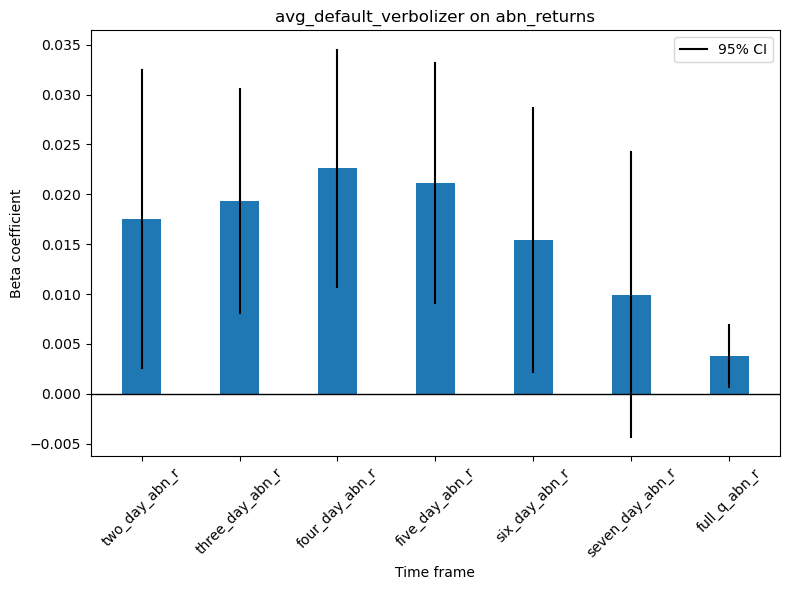

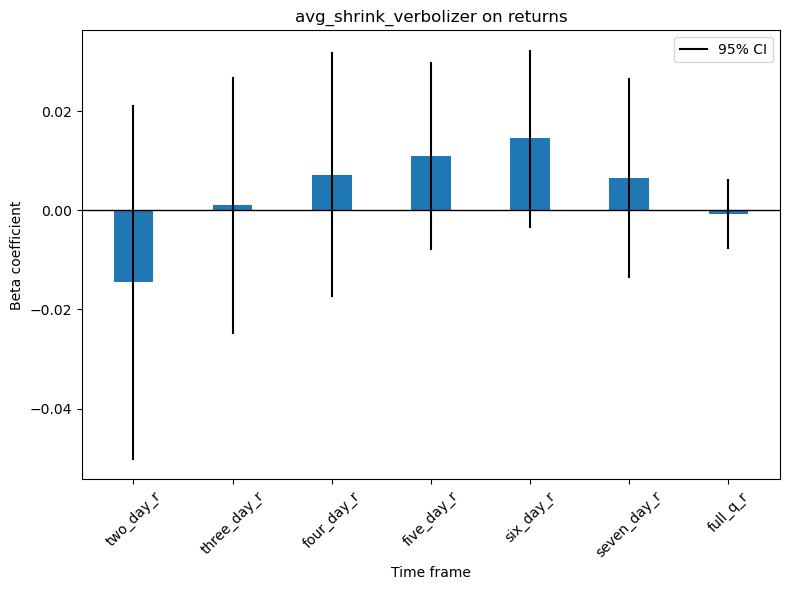

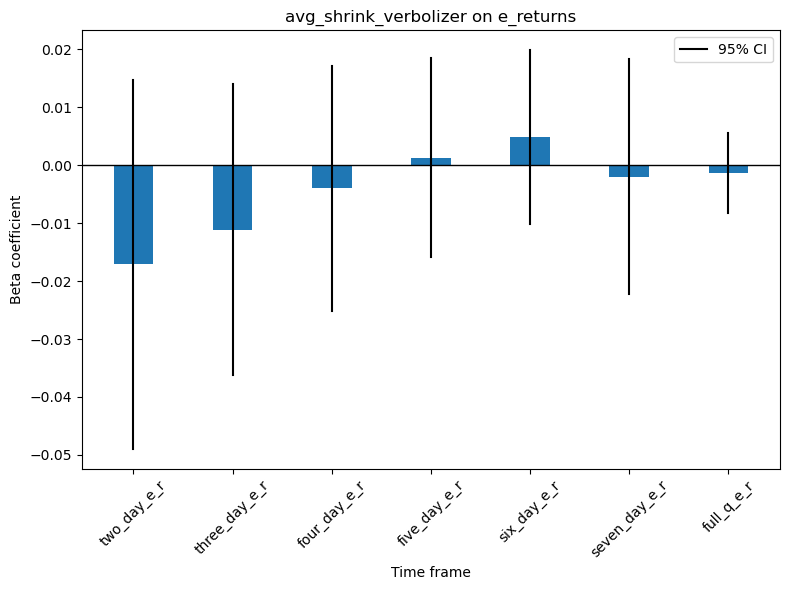

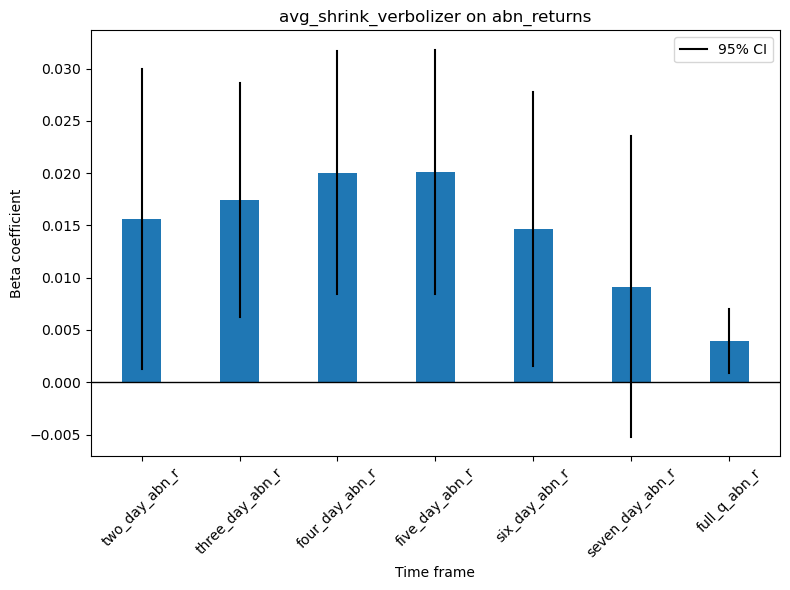

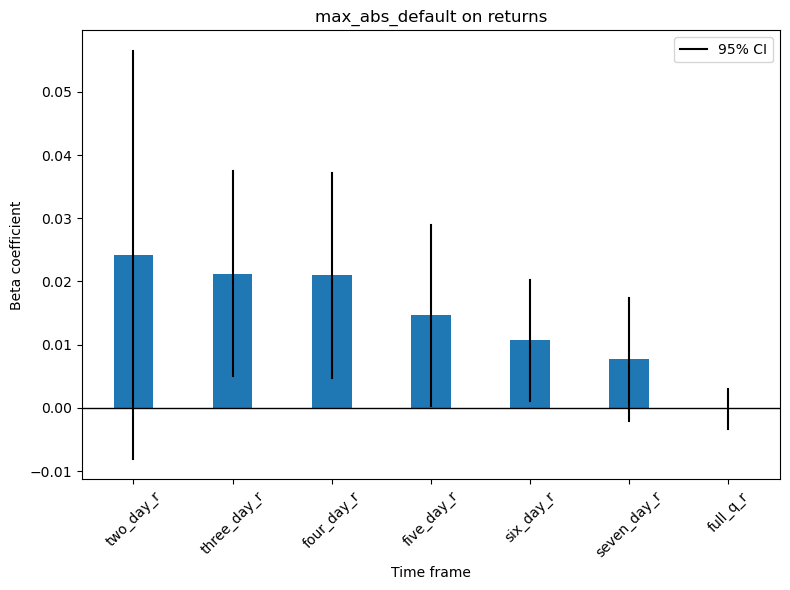

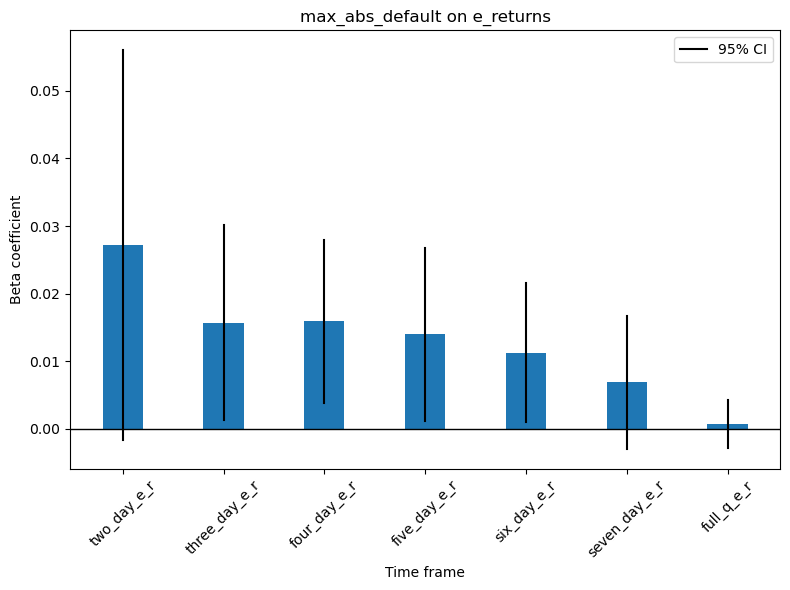

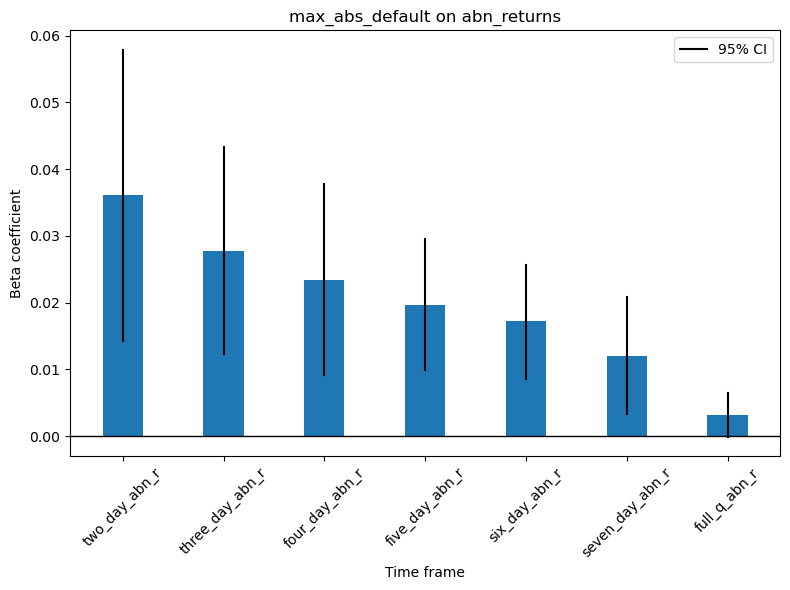

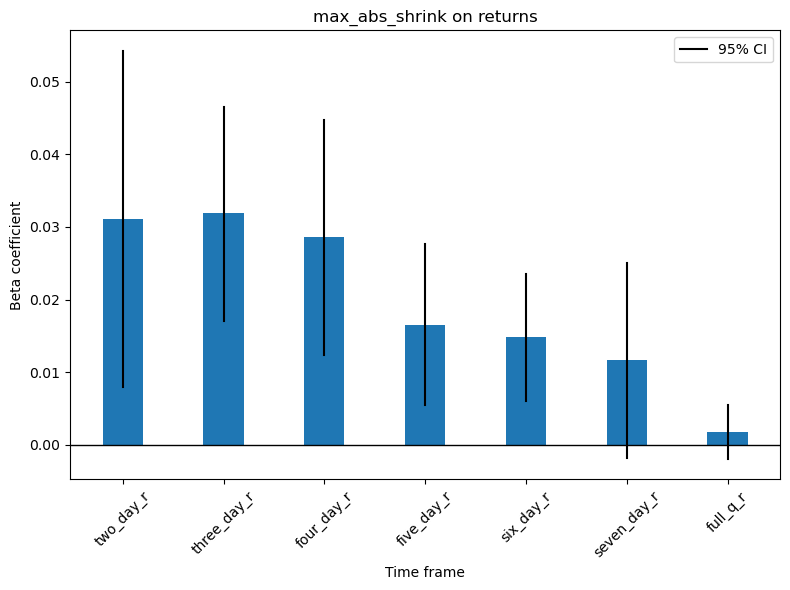

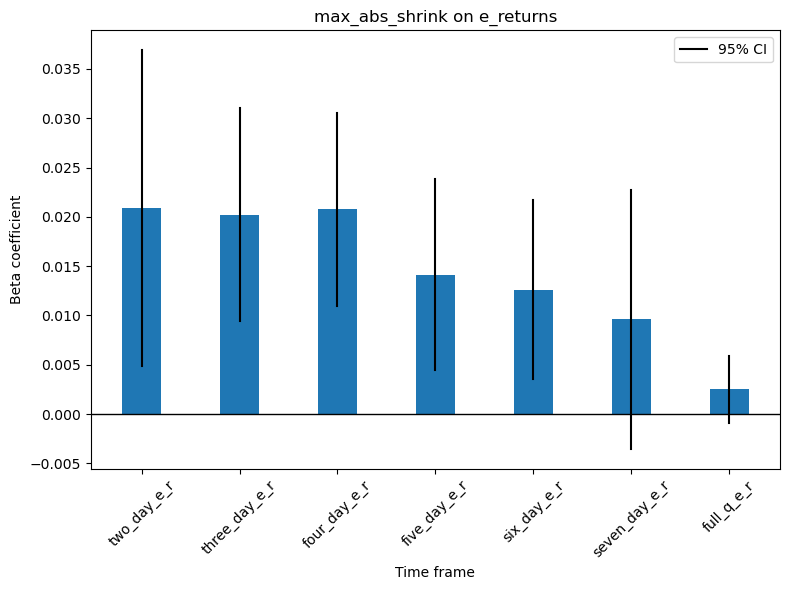

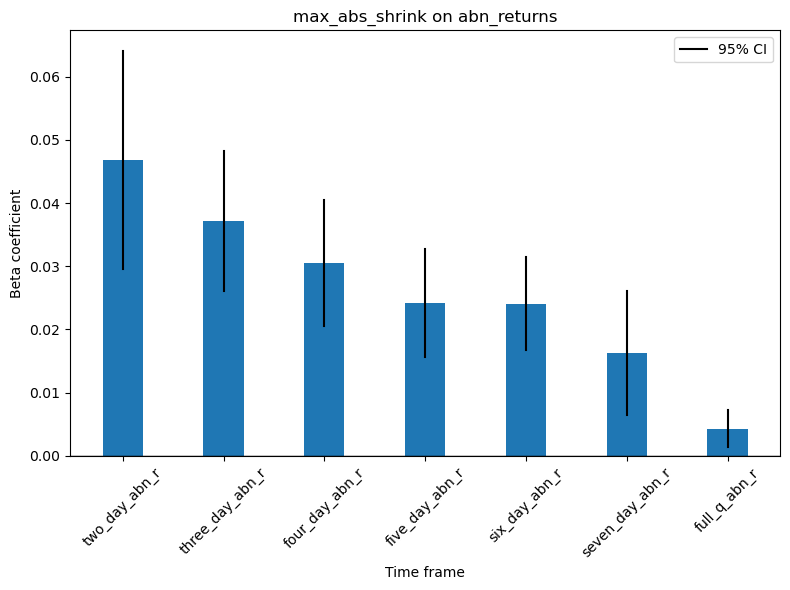

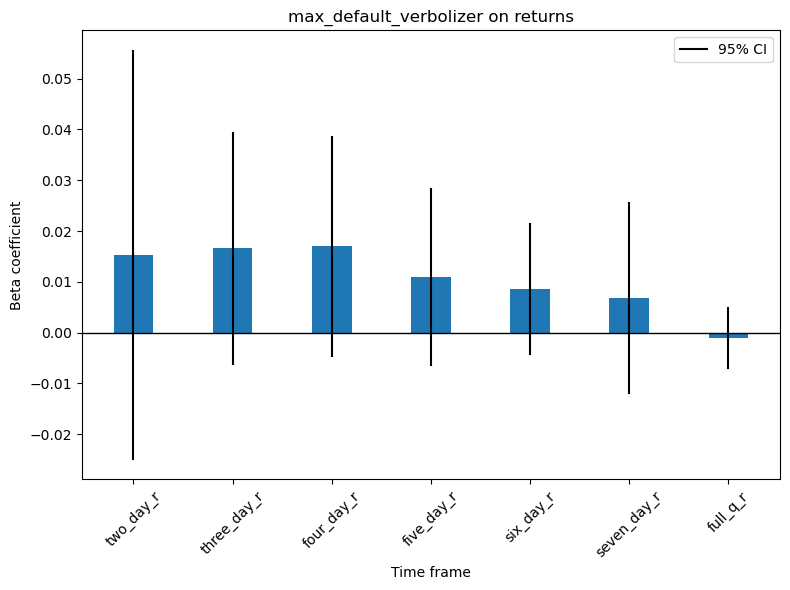

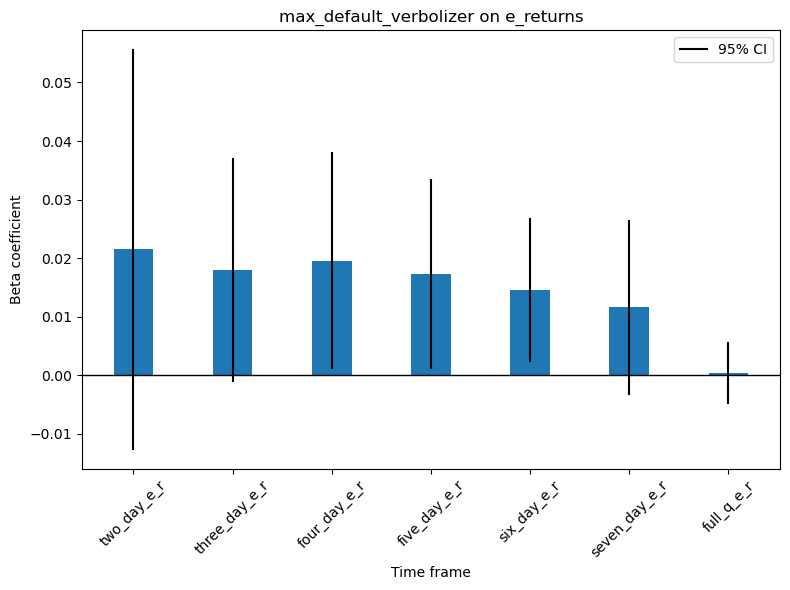

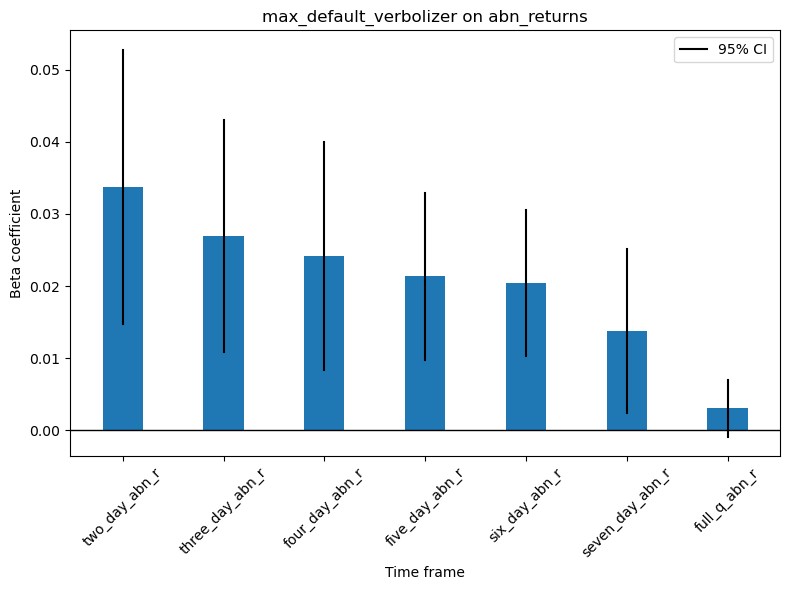

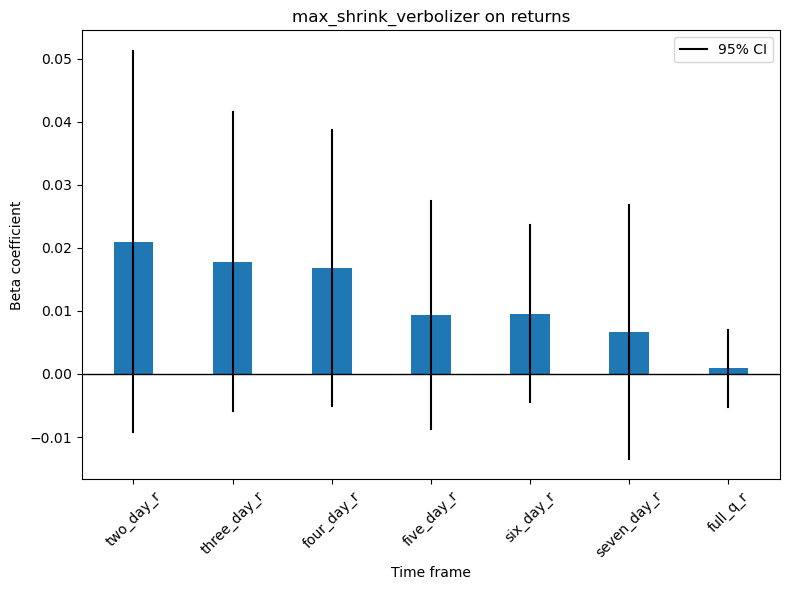

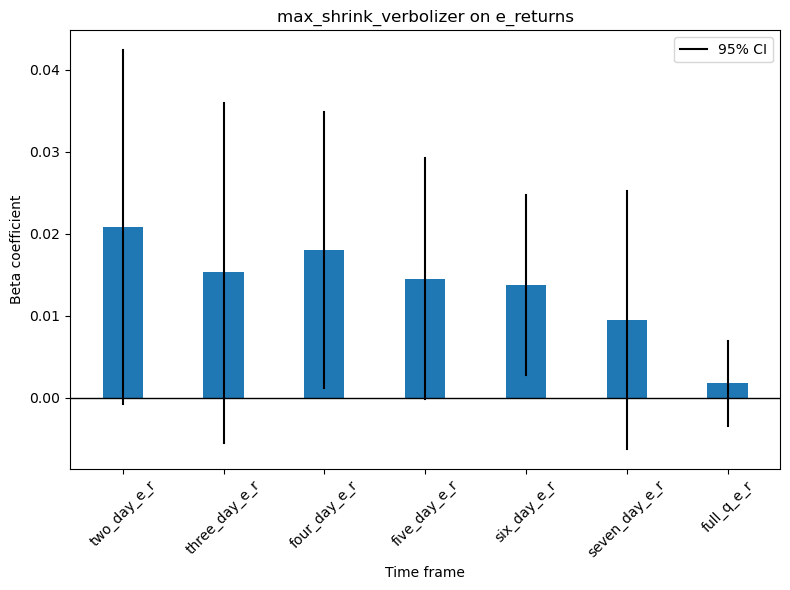

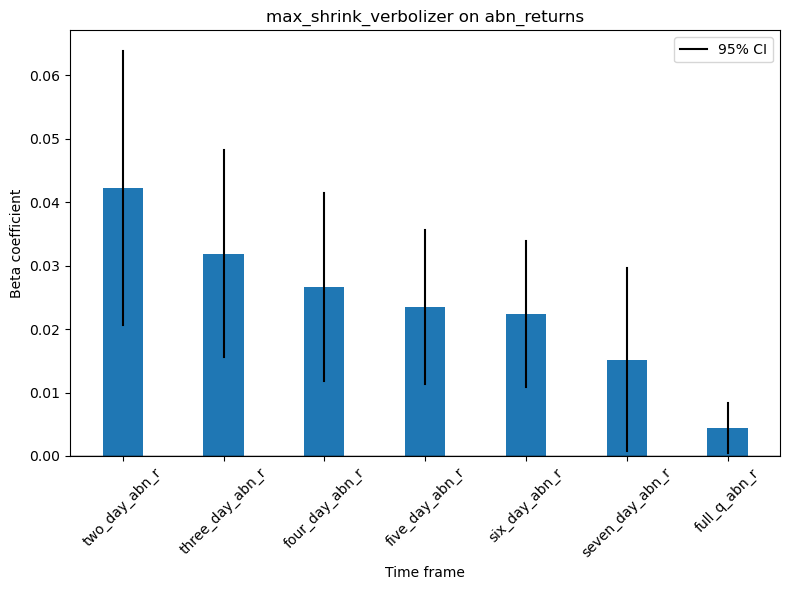

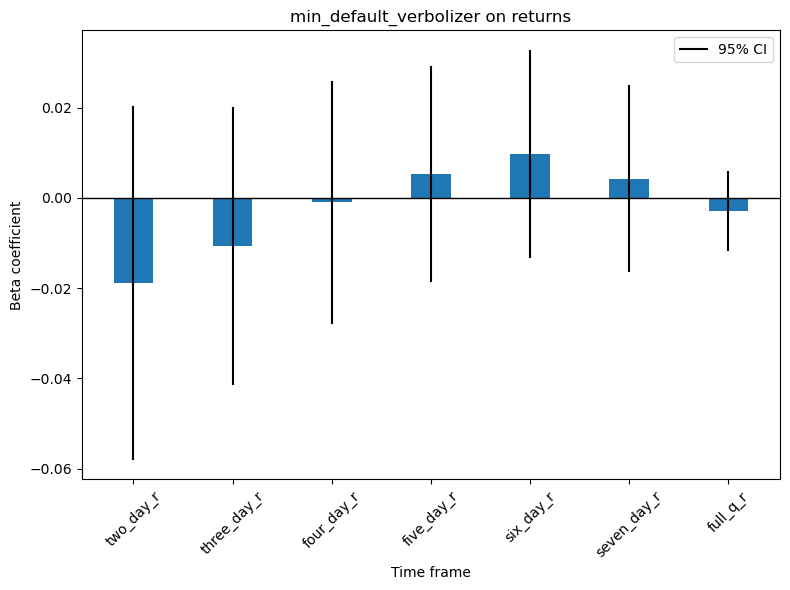

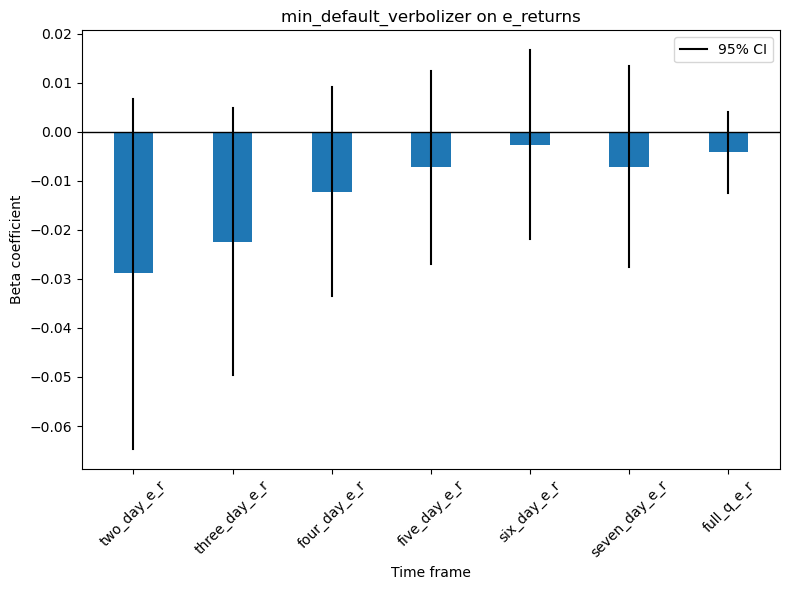

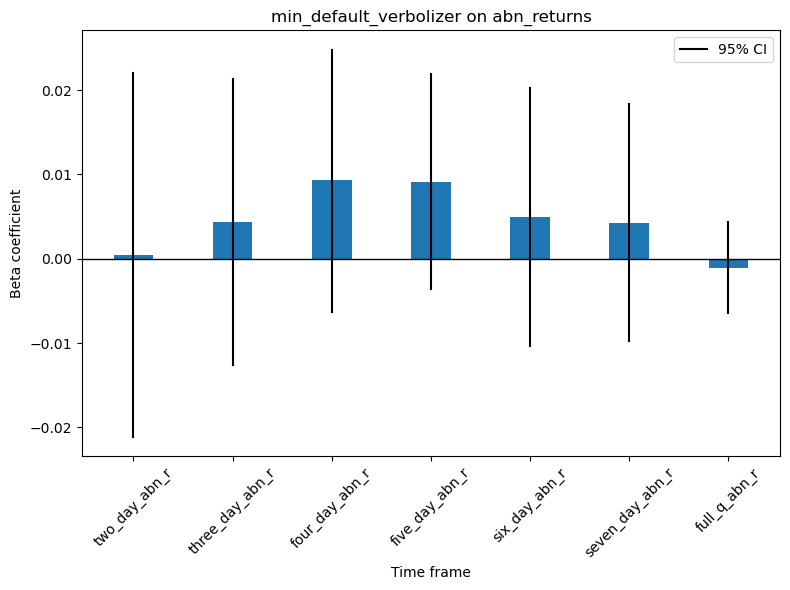

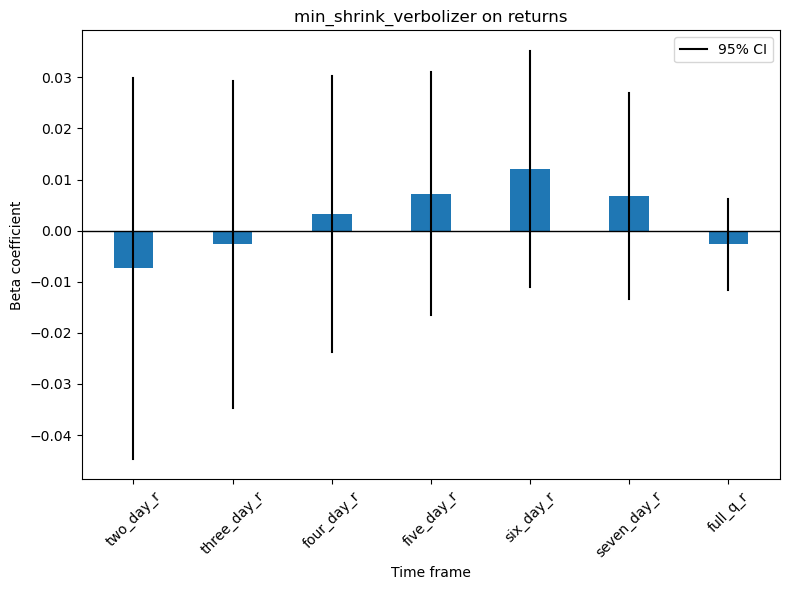

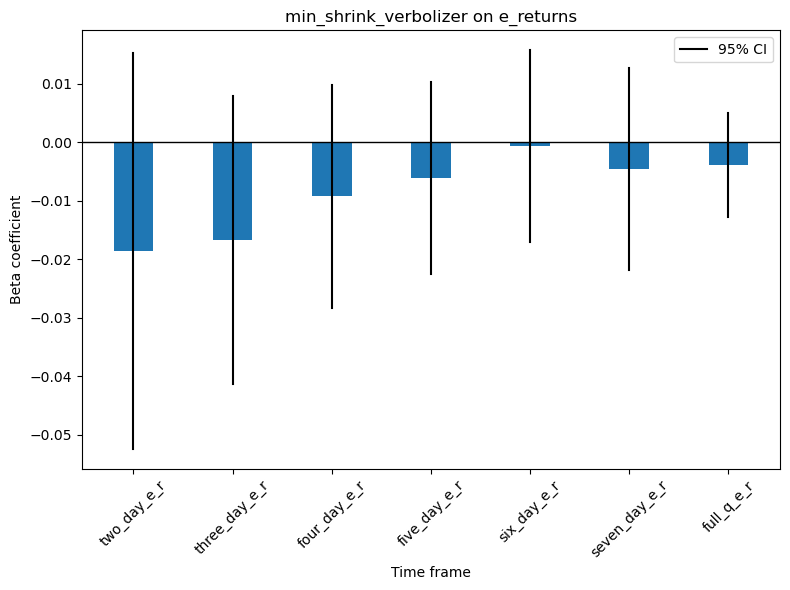

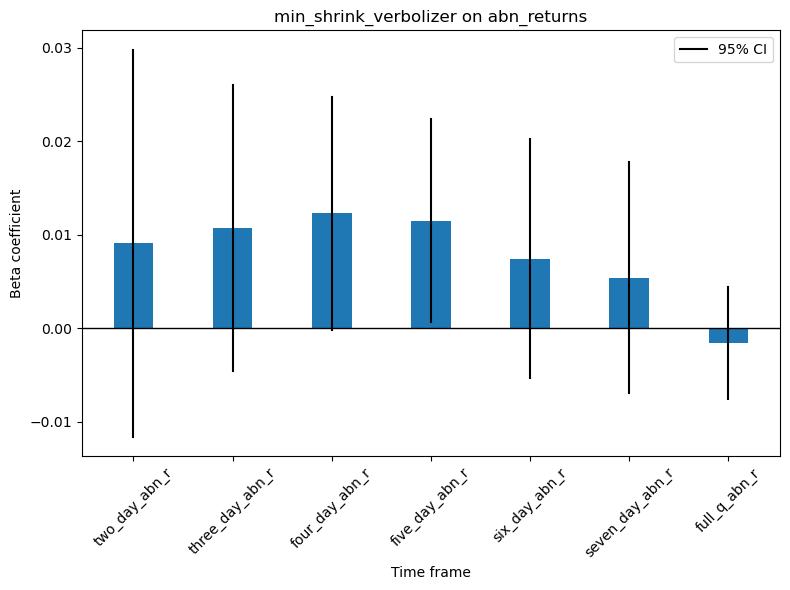

In [31]:
model.plot_all_params()